In [40]:
import os
import glob
import pydicom
import numpy as np
import cv2
from scipy.ndimage import zoom
from tqdm import tqdm
import cv2
import pandas as pd
import math

def get_pixels_hu(slices, convert=False):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    if convert:
        # Convert to Hounsfield units (HU)
        for slice_number in range(len(slices)):

            intercept = slices[slice_number].RescaleIntercept
            slope = slices[slice_number].RescaleSlope
            print(intercept, slope)
            if slope != 1:
                image[slice_number] = slope * image[slice_number].astype(np.float64)
                image[slice_number] = image[slice_number].astype(np.int16)

            image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def load_slices(patient, selective=True):
    '''
    Load slices
    '''
    sorted_imgs = sorted(glob.glob('../datasets/kaggle-brain-tumor/train/'+patient+'/FLAIR/*.dcm'))
    slices = [pydicom.read_file(s) for s in sorted_imgs]
    
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def quantile_filtering(images, lower=0.20, upper=0.80):
    # selective filtering
    num_images = images.shape[0]
    #print(images.shape)
    lb = math.floor(lower*num_images)
    ub = math.floor(upper*num_images)
    images = images[lb:ub]
    #print(images.shape)
    return images
        
def remove_blanks(hu_images):
    '''
    remove blank images form the collection
    '''
    blanked_images = []
    for i in range(hu_images.shape[0]):
        if np.min(hu_images[i]) != np.max(hu_images[i]):
            blanked_images.append(hu_images[i])
    return np.array(blanked_images, dtype=np.int16)

def siz(img):
    desired_depth = 64
    current_depth = img.shape[0]
    depth = current_depth / desired_depth
    depth_factor = 1 / depth
    img_new = zoom(img, (depth_factor, 1, 1), mode='nearest')
    return img_new

def normalize(img, mini, maxi):
    img = (img - mini) / (maxi - mini)
    return img

def resize_images(img, resize_dim=256):
    resized = []
    for i in range(img.shape[0]):
        im = img[i]
        img_t = cv2.resize(im, (resize_dim, resize_dim))
        resized.append(img_t)
    return np.array(resized)

def get_label(patient, df):
    label = df._get_value(patient, 'MGMT_value')
    if label == 1:
        label = np.array(1)
    elif label == 0:
        label = np.array(0)
    return label

def zero_center(images, mean):
    images = images - mean
    return images
    
# Convert the Image Orientation Patient tag cosine values into a text string of the plane.
# This represents the plane the image is 'closest to' .. it does not explain any obliqueness
def get_image_plane(loc):

    row_x = round(loc[0])
    row_y = round(loc[1])
    row_z = round(loc[2])
    col_x = round(loc[3])
    col_y = round(loc[4])
    col_z = round(loc[5])

    if row_x == 1 and row_y == 0 and col_x == 0 and col_y == 0:
        return "Coronal"

    if row_x == 0 and row_y == 1 and col_x == 0 and col_y == 0:
        return "Sagittal"

    if row_x == 1 and row_y == 0 and col_x == 0 and col_y == 1:
        return "Axial"

    return "Unknown"

def cropped_images(images):
    '''
    Input images numpy array (D, H, W) (D = Depth)
    '''
    min_1=np.array(np.nonzero(images)).min(axis=1)
    max_1=np.array(np.nonzero(images)).max(axis=1)
    min_crop = min(min_1[1], min_1[2])
    max_crop = max(max_1[1], max_1[2])
    return images[min_1[0]:max_1[0], min_crop:max_crop,min_crop:max_crop]


## Loop to find number of Sagital, coronal.. FLAIR images

In [36]:
patients = os.listdir('../datasets/kaggle-brain-tumor/train')

sagittal = []
axial = []
coronal = []

for patient in tqdm(patients):
    if patient in ['00109', '00123', '00709']:
        continue
    
    slices = load_slices(patient)
    orientation = get_image_plane(slices[0][0x0020, 0x0037])
    if orientation == "Coronal":
        coronal.append(patient)
    if orientation == "Saggital":
        saggital.append(patient)
    if orientation == "Axial":
        axial.append(patient)
    

100%|██████████| 585/585 [02:30<00:00,  3.89it/s]


In [37]:
print(f'sagittal: {len(sagittal)}, axial: {len(axial)}, coronal: {len(coronal)}')

sagittal: 0, axial: 356, coronal: 197


As you can see ari there are 356 axial
- Approach will be to try a model only on axial images 256x256

In [44]:
import matplotlib.pyplot as plt
# Average number of slices in axial images:
lens = []
for axial_patient in tqdm(axial):
    slices = load_slices(axial_patient)
    lens.append(len(slices))

lens = np.array(lens)
print(f'min: {np.min(lens)}, max: {np.max(lens)}, mean: {np.mean(lens)}')

100%|████████████████████████████████████████████████████████████████████████████████| 356/356 [01:30<00:00,  3.94it/s]

min: 9, max: 309, mean: 39.29494382022472


2

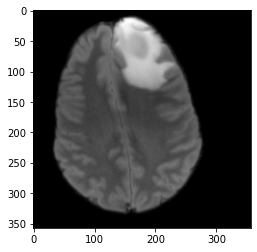

In [43]:
plt.imshow(images[45], cmap='gray')
min(5,2)

So i guess 64 is fine but remove data points that are less than 15

## Find mean, max, min

In [42]:
# find mean, min, max for normalization
output = []
min_val = 1000
max_val = -1000
summer = 0
for patient in tqdm(axial):
    slices = load_slices(patient) 
    #if len(slices) < 10:
    #    removed += 1
    #    continue
    hu_images = get_pixels_hu(slices)
    images = remove_blanks(hu_images)
    if images.shape[0] < 10:
        removed += 1
        continue
    images = quantile_filtering(images, 0.15, 0.85)
    images = cropped_images(images)
    im = []
    for j in range(images.shape[0]):
        im.append(cv2.resize(images[j], (256, 256)))
    images = np.array(im)
    images = siz(images)
    images = normalize(images, mini=-486 , maxi=4738)
    #output.append(images)
    if np.min(images) < min_val:
        min_val = np.min(images)
    if np.max(images) > max_val:
        max_val = np.max(images)
    summer += np.mean(images)

print(min_val)
print(max_val)
print(summer/len(axial))

100%|██████████| 356/356 [10:25<00:00,  1.76s/it]

0.0
1.0
0.12276916973709348


## Main exporter

In [43]:
labels_df = pd.read_csv('../datasets/kaggle-brain-tumor/train_labels.csv', converters={'BraTS21ID': lambda x: str(x)})
labels_df = labels_df.set_index('BraTS21ID')

removed = 0
for patient in tqdm(axial):
    output = []
    slices = load_slices(patient, True)
    images = get_pixels_hu(slices, False)
    images = remove_blanks(images)
    if images.shape[0] <10:
        removed += 1
        continue
        
    images = quantile_filtering(images, 0.15, 0.85)
    images = cropped_images(images)
    im = []
    for j in range(images.shape[0]):
        im.append(cv2.resize(images[j], (256, 256)))
    images = np.array(im)
    images = siz(images)
    images = normalize(images, mini=-403, maxi=4746)
    #zero ceter in preprocessing dataloader
    images = zero_center(images, 0.12276916973709348)
    
    label = labels_df._get_value(patient, 'MGMT_value')
    if label == 1:
        label = np.array(1)
    elif label == 0:
        label = np.array(0)
        
    output.append([images, label])
    all_data_numpy = np.array(output)
    filename = patient + '-AXIAL-QFSIZ.npy'
    np.save(filename, all_data_numpy)
print(f'Remove {removed}')

  0%|          | 0/356 [00:00<?, ?it/s]<ipython-input-43-b1d9b148c28c>:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_data_numpy = np.array(output)
100%|██████████| 356/356 [11:00<00:00,  1.85s/it]

Remove 0


# Checking 

max: 0.7609924195435592 min: -0.07412119475047838


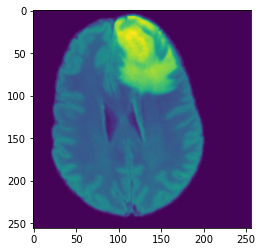

In [33]:
# Convert = True
import matplotlib.pyplot as plt
plt.imshow(all_data_numpy[0][0][45])

print(f'max: {np.max(all_data_numpy[0][0])} min: {np.min(all_data_numpy[0][0])}')

max: 0.5201689586773717 min: -0.03508448859394313


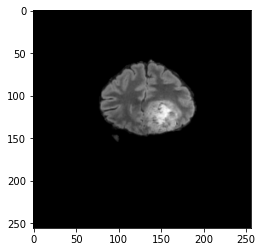

In [14]:
# conevrt  =False
import matplotlib.pyplot as plt
plt.imshow(all_data_numpy[0][0][35], cmap='gray')

print(f'max: {np.max(all_data_numpy[0][0])} min: {np.min(all_data_numpy[0][0])}')

In [55]:
len(os.listdir('.'))

260

In [23]:
patients = os.listdir('../datasets/kaggle-brain-tumor/train')

labels_df = pd.read_csv('../datasets/kaggle-brain-tumor/train_labels.csv', converters={'BraTS21ID': lambda x: str(x)})
labels_df = labels_df.set_index('BraTS21ID')

for patient in tqdm(patients[:10]):
    if patient in ['00109', '00123', '00709']:
        continue
    output = []
    slices = load_slices(patient)
    
    print(get_image_plane(slices[0][0x0020,0x0037]))
    
    hu_images = get_pixels_hu(slices)
    images = remove_blanks(hu_images)
    im = []
    for j in range(images.shape[0]):
        im.append(cv2.resize(images[j], (256, 256)))
    images = np.array(im)
    images = siz(images)
    images = normalize(images)
    
    label = labels_df._get_value(patient, 'MGMT_value')
    if label == 1:
        label = np.array(1)
    elif label == 0:
        label = np.array(0)
    
    output.append([images, label])
    all_data_numpy = np.array(output)
    filename = patient + '.npy'
    np.save(filename, all_data_numpy)


  0%|          | 0/10 [00:00<?, ?it/s]

Coronal


<ipython-input-23-fa92a3ef4707>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_data_numpy = np.array(output)
 10%|█         | 1/10 [00:03<00:34,  3.88s/it]

Sagittal


 20%|██        | 2/10 [00:06<00:27,  3.40s/it]

Sagittal


 30%|███       | 3/10 [00:09<00:22,  3.19s/it]

Coronal


 40%|████      | 4/10 [00:14<00:22,  3.75s/it]

Axial


 50%|█████     | 5/10 [00:17<00:17,  3.48s/it]

Sagittal


 60%|██████    | 6/10 [00:20<00:13,  3.35s/it]

Sagittal


 70%|███████   | 7/10 [00:24<00:10,  3.48s/it]

Sagittal


 80%|████████  | 8/10 [00:27<00:06,  3.41s/it]

Coronal


 90%|█████████ | 9/10 [00:32<00:03,  3.92s/it]

Coronal


100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


In [11]:
print(all_data_numpy[0][0][56])

[[0.07375099 0.07375099 0.07375099 ... 0.07375099 0.07375099 0.07375099]
 [0.07375099 0.07375099 0.07375099 ... 0.07375099 0.07375099 0.07375099]
 [0.07375099 0.07375099 0.07375099 ... 0.07375099 0.07375099 0.07375099]
 ...
 [0.07375099 0.07375099 0.07375099 ... 0.07375099 0.07375099 0.07375099]
 [0.07375099 0.07375099 0.07375099 ... 0.07375099 0.07375099 0.07375099]
 [0.07375099 0.07375099 0.07375099 ... 0.07375099 0.07375099 0.07375099]]


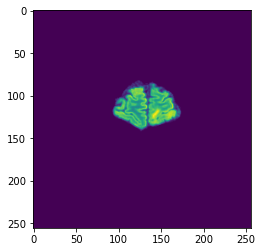

In [17]:
import matplotlib.pyplot as plt
plt.imshow(all_data_numpy[0][0][56])

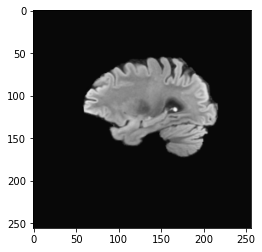

In [26]:
import matplotlib.pyplot as plt
plt.imshow(all_data_numpy[0][0][45], cmap='gray')

In [14]:
os.listdir('./')

['00000.npy', 'converter.ipynb', '.ipynb_checkpoints']

In [15]:
import numpy as np
sata = np.load('./00000.npy', allow_pickle=True)

In [17]:
sata[0][0].shape

(64, 256, 256)

## Evaluating dataset mean

In [9]:
patients = os.listdir('/run/media/aryaman/T7/datasets/kaggle-brain-tumor/train')

labels_df = pd.read_csv('/run/media/aryaman/T7/datasets/kaggle-brain-tumor/train_labels.csv', converters={'BraTS21ID': lambda x: str(x)})
labels_df = labels_df.set_index('BraTS21ID')

output = []
min_val = 1000
max_val = -1000
for patient in tqdm(patients):
    if patient in ['00109', '00123', '00709']:
        continue
    
    slices = load_slices(patient) 
    hu_images = get_pixels_hu(slices)
    images = remove_blanks(hu_images)
    im = []
    for j in range(images.shape[0]):
        im.append(cv2.resize(images[j], (256, 256)))
    images = np.array(im)
    images = siz(images)
    #output.append(images)
    if np.min(images) < min_val:
        min_val = np.min(images)
    if np.max(images) > max_val:
        max_val = np.max(images)

100%|██████████| 585/585 [30:57<00:00,  3.18s/it] 


In [10]:
print(min_val, max_val)

-465 5840
